In [1]:
import numpy as np
#import torch
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from tqdm import tqdm

from time import time

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)

from source.auxiliary_functions import remove_outliers_DDC, apply_estimator, contaminate_bernoulli, low_rank

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from source.real_experiment import clean_abalone

# Missing Values 

#### synthetic data

Here censuring the whole row does not make sense due to the number of dimensions

In [5]:
NREP = 5
N = 10
n_sample=300
p = 20
effective_rank = 5

epsilons = np.linspace(0.0001, 0.5, N)

classical_error = np.zeros((N,NREP))
mean_error = np.zeros((N,NREP))
median_error = np.zeros((N,NREP))
MI_1_error = np.zeros((N,NREP))
MI_time = np.zeros((N, NREP))
knn_error = np.zeros((N,NREP))
knn_time = np.zeros((N,NREP))
MV_error = np.zeros((N,NREP))
MV_time = np.zeros((N, NREP))


for k in tqdm(range(NREP)):
    
    C_true,_ = low_rank(effective_rank, p)
    data = np.random.multivariate_normal(np.zeros(p), C_true, size=n_sample)
    true_norm = np.linalg.norm(C_true, ord=2)
    
    for i, eps in enumerate(epsilons):
        
        missing_data, _ = contaminate_bernoulli(data, eps, intensity=0, option='dirac')
        classical_error[i,k] = np.linalg.norm(np.cov(missing_data.T) - C_true, ord=2)/true_norm
        
        missing_data[missing_data == 0] = np.nan
        
        #2. mean and median imputation
        mean_data = np.zeros(data.shape)
        med_data = np.zeros(data.shape)
        for dim in range(data.shape[1]):
            marginal = missing_data[:, dim]
            m = np.mean(marginal[~np.isnan(marginal)])
            M = np.median(marginal[~np.isnan(marginal)])

            mean_marginal = marginal.copy()
            mean_marginal[np.isnan(marginal)] = m
            mean_data[:, dim] = mean_marginal

            med_marginal = marginal.copy()
            med_marginal[np.isnan(marginal)] = M
            med_data[:, dim] = med_marginal

        C_mean = np.cov(mean_data.T)
        C_med = np.cov(med_data.T)
        
        mean_error[i,k] = np.linalg.norm(C_mean - C_true, ord=2)/true_norm
        median_error[i,k] = np.linalg.norm(C_med- C_true, ord=2)/true_norm

        #3. multiple imputation (inspired by MICE)
        tstart = time()
        imputer = IterativeImputer(max_iter=10, random_state=0)
        MI_data = imputer.fit_transform(missing_data)
        tend = time()
        C_MI_1 = np.cov(MI_data.T)
        MI_1_error[i,k] = np.linalg.norm(C_MI_1 - C_true, ord=2)/true_norm
        MI_time[i,k] = tend - tstart

        #4. knnimpute
        tstart = time()
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        knn_data = imputer.fit_transform(missing_data)  
        C_knn = np.cov(knn_data.T)
        tend = time()
        knn_error[i,k] = np.linalg.norm(C_knn - C_true, ord=2)/true_norm
        knn_time[i,k] = tend - tstart

        #4. MVestimator
        tstart = time()
        mask = (np.isnan(missing_data)).astype(int)
        C_MV, _ = apply_estimator('oracleMV', missing_data, mask=mask)
        tend = time()
        MV_error[i,k] = np.linalg.norm(C_MV - C_true, ord=2)/true_norm
        MV_time[i,k] = tend - tstart

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
 20%|█████████████████████████████████▊                                                                                                                                       | 1/5 [00:01<00:05,  1.44s/it]/Users/gregoi

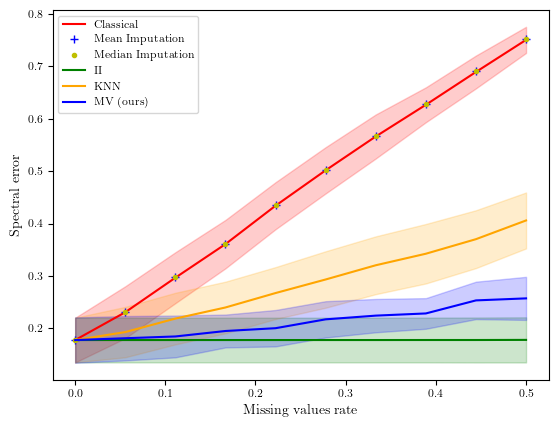

In [9]:
plt.plot(epsilons, classical_error.mean(axis=-1), label='Classical', color='r')
plt.fill_between(epsilons, classical_error.mean(axis=-1) - classical_error.std(axis=-1), classical_error.mean(axis=-1) + classical_error.std(axis=-1), color='r', alpha=0.2)
plt.plot(epsilons, mean_error.mean(axis=-1),'+b', label='Mean Imputation')
plt.plot(epsilons, median_error.mean(axis=-1), '.y', label='Median Imputation')
plt.plot(epsilons, MI_1_error.mean(axis=-1), label='II', color='g')
plt.fill_between(epsilons, MI_1_error.mean(axis=-1) - MI_1_error.std(axis=-1), MI_1_error.mean(axis=-1) + MI_1_error.std(axis=-1), color='g', alpha=0.2)
#plt.plot(epsilons, MI_2_error.mean(axis=-1), label='ExtraTrees MI')
plt.plot(epsilons, knn_error.mean(axis=-1), label='KNN', color='orange')
plt.fill_between(epsilons, knn_error.mean(axis=-1) - knn_error.std(axis=-1), knn_error.mean(axis=-1) + knn_error.std(axis=-1), color='orange', alpha=0.2)
plt.plot(epsilons, MV_error.mean(axis=-1), label='MV (ours)', color='b')
plt.fill_between(epsilons, MV_error.mean(axis=-1) - MV_error.std(axis=-1), MV_error.mean(axis=-1) + MV_error.std(axis=-1), color='b', alpha=0.2)
plt.legend()
plt.xlabel('Missing values rate')
plt.ylabel('Spectral error')
plt.savefig("synthetic_missing_data_500_bis.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [142]:
print(knn_time.mean(), knn_time.std())
print(MI_time.mean(), MI_time.std())
print(MV_time.mean(), MV_time.std())

0.4123829746246338 0.17656088139578718
165.57528636455535 379.9182526795382
0.009749813079833984 0.004981338651081007


Abalone

In [6]:
data = pd.read_csv('abalone.data', sep=',', header=None)
data, _ = clean_abalone()

In [7]:
data.shape

(4173, 7)

In [8]:
A = np.cov(data.T)
np.trace(A)/np.linalg.norm(A, ord=2)

1.0530320651238438

In [80]:
# comparing our estimator to median imputation, mean inputation, multiple imputation
NREP = 30
N = 20

data = pd.read_csv('abalone.data', sep=',', header=None)
data = clean_abalone(data)

classical_error = np.zeros((N,NREP))
censured_error = np.zeros((N,NREP))
mean_error = np.zeros((N,NREP))
median_error = np.zeros((N,NREP))
MI_1_error = np.zeros((N,NREP))
knn_error = np.zeros((N,NREP))
MV_error = np.zeros((N,NREP))

from sklearn.impute import IterativeImputer, KNNImputer

C_true = np.cov(data.T)
true_norm = np.linalg.norm(C_true, ord=2)

epsilons = np.linspace(0.0001, 0.3, N)

for i,eps in enumerate(tqdm(epsilons)):
    for k in range(NREP):
        missing_data, _ = contaminate_bernoulli(data, eps, intensity=0, option='dirac')
        classical_error[i,k] = np.linalg.norm(np.cov(missing_data.T) - C_true, ord=2)/true_norm
        
        missing_data[missing_data == 0] = np.nan
        
        #1. drop line
        censured_data = missing_data[~np.any(np.isnan(missing_data), axis=1)]
        C_censured = np.cov(censured_data.T)
        censured_error[i,k] = np.linalg.norm(C_censured - C_true, ord=2)/true_norm

        #2. mean and median imputation
        mean_data = np.zeros(data.shape)
        med_data = np.zeros(data.shape)
        for dim in range(data.shape[1]):
            marginal = data[:, dim]
            m = np.mean(marginal[~np.isnan(marginal)])
            M = np.median(marginal[~np.isnan(marginal)])

            mean_marginal = marginal.copy()
            mean_marginal[~np.isnan(marginal)] = m
            mean_data[:, dim] = mean_marginal

            med_marginal = marginal.copy()
            med_marginal[~np.isnan(marginal)] = M
            med_data[:, dim] = med_marginal

        C_mean = np.cov(mean_data.T)
        C_med = np.cov(med_data.T)
        
        mean_error[i,k] = np.linalg.norm(C_mean - C_true, ord=2)/true_norm
        median_error[i,k] = np.linalg.norm(C_med- C_true, ord=2)/true_norm

        #3. multiple imputation (inspired by MICE)
        imputer = IterativeImputer(max_iter=10, random_state=0)
        MI_data = imputer.fit_transform(missing_data)
        C_MI_1 = np.cov(MI_data.T)
        MI_1_error[i,k] = np.linalg.norm(C_MI_1 - C_true, ord=2)/true_norm

        #4. knnimpute
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        knn_data = imputer.fit_transform(missing_data)    
        C_knn = np.cov(knn_data.T)
        knn_error[i,k] = np.linalg.norm(C_knn - C_true, ord=2)/true_norm

        #4. MVestimator
        mask = (np.isnan(missing_data)).astype(int)
        C_MV, _ = apply_estimator('oracleMV', missing_data, mask=mask)
        MV_error[i,k] = np.linalg.norm(C_MV - C_true, ord=2)/true_norm

  5%|████████▍                                                                                                                                                               | 1/20 [00:01<00:22,  1.21s/it]/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/o

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [02:10<02:24, 16.08s/it]/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/o

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [03:54<01:21, 20.50s/it]/Users/gregoirepacreau/o

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

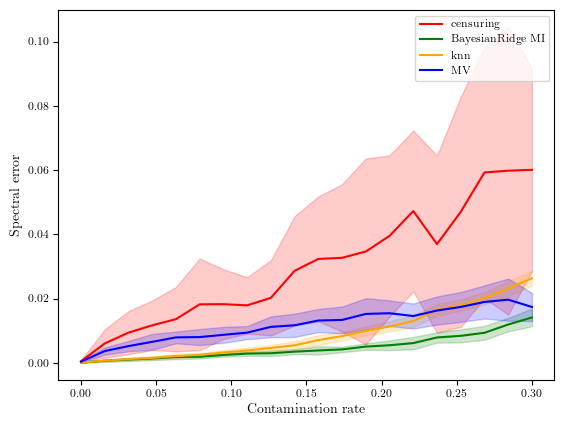

In [81]:
#plt.plot(epsilons, classical_error.mean(axis=-1), label='classical', color='r')
plt.plot(epsilons, censured_error.mean(axis=-1), label='censuring', color='r')
plt.fill_between(epsilons, censured_error.mean(axis=-1)-censured_error.std(axis=-1), censured_error.mean(axis=-1)+censured_error.std(axis=-1), alpha=0.2, color='r')
#plt.plot(epsilons, mean_error.mean(axis=-1), label='mean')
#plt.plot(epsilons, median_error.mean(axis=-1), label='median')
plt.plot(epsilons, MI_1_error.mean(axis=-1), label='BayesianRidge MI', color='g')
plt.fill_between(epsilons, MI_1_error.mean(axis=-1)-MI_1_error.std(axis=-1), MI_1_error.mean(axis=-1)+MI_1_error.std(axis=-1), alpha=0.2, color='g')
#plt.plot(epsilons, MI_2_error.mean(axis=-1), label='ExtraTrees MI')
plt.plot(epsilons, knn_error.mean(axis=-1), label='knn', color='orange')
plt.fill_between(epsilons, knn_error.mean(axis=-1)-knn_error.std(axis=-1), knn_error.mean(axis=-1)+knn_error.std(axis=-1), alpha=0.2, color='orange')
plt.plot(epsilons, MV_error.mean(axis=-1), label='MV', color='b')
plt.fill_between(epsilons, MV_error.mean(axis=-1)-MV_error.std(axis=-1), MV_error.mean(axis=-1)+MV_error.std(axis=-1), alpha=0.2, color='b')
plt.legend()
plt.xlabel('Contamination rate')
plt.ylabel('Spectral error')
plt.savefig("abalone_missing_data.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [21]:
# same experiment but fewer samples

In [98]:
Ndataset = 20
N = 3

#1. découpage d'Abalone en plusieurs morceaux

data = pd.read_csv('abalone.data', sep=',', header=None)
data = clean_abalone(data)

np.random.shuffle(data)
splits = [(i+1) * data.shape[0]//Ndataset for i in range(Ndataset)]
datas = np.split(data, splits)[:-1]
print(data.shape[0]//Ndataset)

#2. appliquer le code précédent aux morceaux

classical_error = np.zeros((N,Ndataset))
censured_error = np.zeros((N,Ndataset))
mean_error = np.zeros((N,Ndataset))
median_error = np.zeros((N,Ndataset))
MI_1_error = np.zeros((N,Ndataset))
knn_error = np.zeros((N,Ndataset))
MV_error = np.zeros((N,Ndataset))

C_true = np.cov(data.T)
true_norm = np.linalg.norm(C_true, ord=2)

epsilons = np.linspace(0.0001, 0.3, N)

for i,eps in enumerate(tqdm(epsilons)):
    for k, dataset in enumerate(datas):
        missing_data, _ = contaminate_bernoulli(data, eps, intensity=0, option='dirac')
        classical_error[i,k] = np.linalg.norm(np.cov(missing_data.T) - C_true, ord=2)/true_norm
        
        missing_data[missing_data == 0] = np.nan
        
        #1. drop line
        censured_data = missing_data[~np.any(np.isnan(missing_data), axis=1)]
        C_censured = np.cov(censured_data.T)
        censured_error[i,k] = np.linalg.norm(C_censured - C_true, ord=2)/true_norm

        #3. multiple imputation (inspired by MICE)
        imputer = IterativeImputer(max_iter=10, random_state=0)
        MI_data = imputer.fit_transform(missing_data)
        C_MI_1 = np.cov(MI_data.T)
        MI_1_error[i,k] = np.linalg.norm(C_MI_1 - C_true, ord=2)/true_norm

        #4. knnimpute
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        knn_data = imputer.fit_transform(missing_data)    
        C_knn = np.cov(knn_data.T)
        knn_error[i,k] = np.linalg.norm(C_knn - C_true, ord=2)/true_norm

        #4. MVestimator
        mask = (np.isnan(missing_data)).astype(int)
        C_MV, _ = apply_estimator('oracleMV', missing_data, mask=mask)
        MV_error[i,k] = np.linalg.norm(C_MV - C_true, ord=2)/true_norm

208


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 1/3 [00:00<00:01,  1.35it/s]/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/o

/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/opt/anaconda

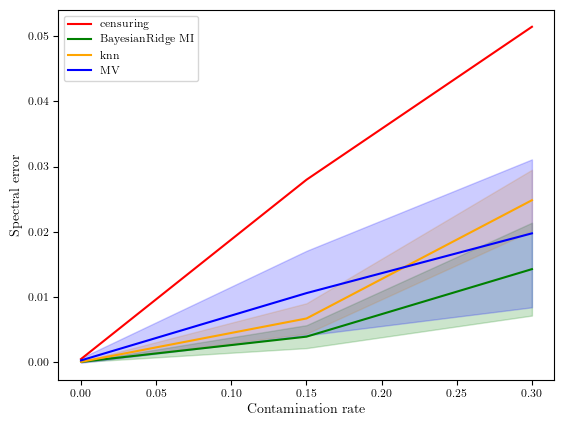

In [102]:
plt.plot(epsilons, censured_error.mean(axis=-1), label='censuring', color='r')
#plt.fill_between(epsilons, censured_error.mean(axis=-1)-1.96*censured_error.std(axis=-1), censured_error.std(axis=-1)+1.96*censured_error.std(axis=-1), color='r', alpha=0.2)
plt.plot(epsilons, MI_1_error.mean(axis=-1), label='BayesianRidge MI', color='g')
plt.fill_between(epsilons, MI_1_error.mean(axis=-1)-1.96*MI_1_error.std(axis=-1), MI_1_error.mean(axis=-1)+1.96*MI_1_error.std(axis=-1), color='g', alpha=0.2)
plt.plot(epsilons, knn_error.mean(axis=-1), label='knn', color='orange')
plt.fill_between(epsilons, knn_error.mean(axis=-1)-1.96*knn_error.std(axis=-1), knn_error.mean(axis=-1)+1.96*knn_error.std(axis=-1), color='orange', alpha=0.2)
plt.plot(epsilons, MV_error.mean(axis=-1), label='MV', color='b')
plt.fill_between(epsilons, MV_error.mean(axis=-1)-1.96*MV_error.std(axis=-1), MV_error.mean(axis=-1)+1.96*MV_error.std(axis=-1), color='b', alpha=0.2)
plt.legend()
plt.xlabel('Contamination rate')
plt.ylabel('Spectral error')
plt.savefig("abalone_missing_data_small_dim.pdf", format='pdf', bbox_inches='tight')
plt.show()

# estiamtor comparison

In [ ]:

new_cov_1, _ = apply_estimator('DDCMV95', data, None, delta=None)
new_cov_2, _ = apply_estimator('DDCMV90', data, None, delta=None)
new_cov_tsgs, _ = apply_estimator('TSGS', data, None, delta=None)
new_cov_di, _ = apply_estimator('DI', data, None, delta=None)
true_norm = numpy.linalg.norm(C, ord=2)
​
print('Relative difference between the classical covariance and:')
print(' - DDCMV95:', numpy.linalg.norm(new_cov_1 - C, ord=2)/true_norm)
print(' - DDCMV90:', numpy.linalg.norm(new_cov_2 - C, ord=2)/true_norm)
print(' - TSGS    :', numpy.linalg.norm(new_cov_tsgs - C, ord=2)/true_norm)
print(' - DI      :', numpy.linalg.norm(new_cov_di - C, ord=2)/true_norm)
print()
print('Relative difference between DDCMV95 and:')
print(' - DDCMV90:', numpy.linalg.norm(new_cov_1 - new_cov_2, ord=2)/max(numpy.linalg.norm(new_cov_1, ord=2), numpy.linalg.norm(new_cov_2, ord=2)))
print(' - TSGS   :', numpy.linalg.norm(new_cov_1 - new_cov_tsgs, ord=2)/max(numpy.linalg.norm(new_cov_1, ord=2), numpy.linalg.norm(new_cov_tsgs, ord=2)))
print(' - DI     :', numpy.linalg.norm(new_cov_1 - new_cov_di, ord=2)/max(numpy.linalg.norm(new_cov_1, ord=2), numpy.linalg.norm(new_cov_di, ord=2)))
print()
print('Relative difference between DDCMV90 and:')
print(' - TSGS   :', numpy.linalg.norm(new_cov_2 - new_cov_tsgs, ord=2)/max(numpy.linalg.norm(new_cov_2, ord=2), numpy.linalg.norm(new_cov_tsgs, ord=2)))
print(' - DI     :', numpy.linalg.norm(new_cov_2 - new_cov_di, ord=2)/max(numpy.linalg.norm(new_cov_2, ord=2), numpy.linalg.norm(new_cov_di, ord=2)))
print()
print('Relative difference between TSGS and DI:')
print(' - ', numpy.linalg.norm(new_cov_tsgs - new_cov_di, ord=2)/max(numpy.linalg.norm(new_cov_tsgs, ord=2), numpy.linalg.norm(new_cov_di, ord=2)))
